In [1]:
import numpy as np
import torch
import sympy as smp
import matplotlib.pyplot as plt
from torchquad import Simpson, set_up_backend
from scipy.integrate import nquad
import inspect

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_up_backend("torch", data_type="float32")

C:\Users\Andi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


# torchquad vs. SciPy Basic Usage

Integrat $f(x_1, x_2, x_3, x_4, x_5) = \sum_{i=1}^5 \sin{(x_i)}$ from 0 to 1 in each of the $x_i$:

$$ \int_{0}^{1} \dots \int_{0}^{1} \sum_{i=1}^5 \sin{(x_i)}dx_1dx_2dx_3dx_4dx_5$$

We know the ground truth of this integral is $10 \sin^2(1/2)$

- The NumPy integrand function needs to take in 5 arguments. By using `*x` as input, it will automatically take all the input arguments to the function and turn it into a tuple. It returns a single number.
- The PyTorch integrand function takes in a tehnsor of shape `[n_points, n_dimensions]` and outputs `[n_points]` (the value of the intgrand at each integration point ). That is why we sum along `dim=1` in the pytorch integrand function.

In [2]:
def integrand_numpy(*x):
    return np.sum(np.sin(x))

def integrand_pytorch(x):
    return torch.sum(torch.sin(x), dim=1)

Let's compare how log it takes to run

In [3]:
dimension = 5
integrand_domain = [[0,1]] * dimension
ground_truth = 2 * dimension * np.sin(0.5) **2

- NumPy/Scipy (CPU)

In [8]:
%%timeit
result_numpy = nquad(integrand_numpy, integrand_domain)[0]

11.5 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- PyTorch/TorchQuad (GPU)

In [9]:
%%timeit
N = 37 ** dimension
simp = Simpson() # initialize Simpson solver
result_pytorch = simp.integrate(integrand_pytorch, dim=dimension, N=N, integration_domain=integrand_domain)

C:\Users\Andi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


42.7 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Note that they are both exactly equak to the ground truth

In [11]:
print(f'Ground truth : {ground_truth:.6f}')
print(f'NumPy/Scipy : {result_numpy:.6f}')
print(f'PyTorch/TorchQuad : {result_pytorch:.6f}')

Ground truth : 2.298488
NumPy/Scipy : 2.298488
PyTorch/TorchQuad : 2.298488


# A More Interesting Physics Use Case

![Image Alt Text](images\magnet_fall.png)


A cylindrical bar magnet of total magnetization $\\vec{m}$ (isotropic, pointing in $\\hat{z}$) is falling through a loop of wire. Due to the changing magnetic flux in the loop, a current $I$ is induced. Find the current as a function of time $t$ if the magnet has the dimensions above and is dropped from an initial height $h_0L$.

Note that

$$ I(t) 
= - \frac{\partial \Phi}{\partial t} 
= \frac{\partial}{\partial t} \iint_{loop} \vec{B} \cdot d \vec{\sigma} 
= \frac{\partial}{\partial t} \iint_{loop} (∇ \times \vec{A}) \cdot d \vec{\sigma} 
= \frac{\partial}{\partial t} \oint_{loop} \vec{A} \cdot d \vec{r} 
= - \oint_{loop} \frac{\partial \vec{A}}{\partial t} \cdot d \vec{r}
$$

So we just need to find $\vec{A}$ from the bar magnet as a function of time and then $\frac{\partial \vec{A}}{\partial t}$.

- If the bar magnet has a total magnetization $m\hat{z}$ then it has a density $\vec{M} = \frac{m}{\pi a^2 L^3}\hat{z} $
- The position of some point on the current loop is $\vec{r}(\phi) = \langle RL \cos{(\phi)}, RL \sin{(\phi)}, 0 ⟩$

- The position of some point on the bar magnet is $\vec{r}(r', z', \phi ') = ⟨r' \cos{(\phi *)}, r' \sin{(\phi *)}, h(t) + z'⟩$ where $h(t)$ corresponds to the bottom $z$ coordinate of the magnet, given by $h(t) = h_0L - \frac{1}{2}gt^2$

- The contribution to $d\vec{A}$ from a dipole is $d\vec{A}=\frac{\mu_0}{4\pi}\frac{\vec{M}\times(\vec{r} -\vec{r'})}{|\vec{r} -\vec{r'}|^3}d\tau = \frac{\mu_0 m}{4\pi L^3a^2}\frac{\vec{z}\times(\vec{r} -\vec{r'})}{|\vec{r} -\vec{r'}|^3} dτ$. This needs to be integrated over the entire cylinder to get $\vec{A}=\iiint_{magnet}d\vec{A}$

The total integral is expressedd as the following (using $d\vec{A} = \frac{d\vec{A}}{dτ}d\tau$ and $d\vec{r} = \frac{d\vec{r}}{d\phi}d\phi$, and alos using $d\tau = r'dr'd\phi 'dz'$ 

$$
\bar{I} = - \oint_{loop} \iiint_{magnet} frac{\partial}{\partial t} (\frac{d\vec{A}}{d\tau}\frac{d\vec{r}}{d\phi})r'dr'd\phi 'dz'
=- \int_0^{2\pi} \int_0^{aL} \int_0^{2\pi} \int_0^L frac{\partial}{\partial t} (\frac{d\vec{A}}{d\tau}\frac{d\vec{r}}{d\phi})r'dr'd\phi 'dz'
$$

WE will instead solve for $\bar{I} = \frac{4\pi^2L^2}{\mu_0m}I$ as a function of $\bar{t} = \sqrt{g/L} \cdot t$, as this makes both quantities dimentionless. In the expression below, all distances  are expressed in units of $L$, and $d\vec{A}/d\tau$ now refers to $\frac{1}{a^2}\frac{\hat{z}\times/(\vec{r}-\vec{r'})}{|\vec{r} -\vec{r'}|^3}


$$
\bar{I}(\bar{t}) = - \int_0^{2\pi} \int_0^a \int_0^{2\pi} \int_0^1 \frac{\partial}{\partial t} (\frac{d\vec{A}}{d\tau}\frac{d\vec{r}}{d\phi})r'dr'd\phi 'dz'
$$

We can obtain this expression below using Sympy:

In [13]:
R, phi, rp, phip, zp, t, h0, a, R, c = smp.symbols("r \phi r' \phi' z' t, h_0 a R c ", real = True)

Define the height h(t)

In [14]:
h = h0 - smp.Rational(1,2) * t**2

Find the integrand

In [20]:
r_vec = smp.Matrix([R*smp.cos(phi), R*smp.sin(phi),0])
rp_vec = smp.Matrix([c +rp*smp.cos(phip), rp*smp.sin(phip), h +zp])
sep_vec = r_vec - rp_vec
M = smp.Matrix([0,0,1])
dAdTau = 1/a**2 * M.cross(sep_vec) /sep_vec.norm()**3
dr_vecdphi = smp.diff(r_vec, phi)
integrand = -smp.diff(dAdTau.dot(dr_vecdphi), t)*rp
integrand.simplify()

48*R*r'*t*(-R + c*cos(\phi) + r'*cos(\phi - \phi'))*(2*h_0 - t**2 + 2*z')/(a**2*(4*R**2 - 8*R*c*cos(\phi) - 8*R*r'*cos(\phi - \phi') + 4*c**2 + 8*c*r'*cos(\phi') + 4*h_0**2 - 4*h_0*t**2 + 8*h_0*z' + 4*r'**2 + t**4 - 4*t**2*z' + 4*z'**2)**(5/2))

Hackish way to convert to pytorch function with name `integrand_f_pytorch`

In [30]:
#1. Convert to numpy function
integrand_f = smp.lambdify([rp, phip,zp,phi,t,a,R,c,h0], integrand)
#2. Convert from numpy function to pytorch function
exec(inspect.getsource(integrand_f).replace('cos', 'torch.cos').replace('sin', 'torch.sin').replace('_lambdifygenerated', 'integrand_f_pytorch'))

For solving the integral

In [37]:
def solve(t,a,h0,R,c,N=37**4):
    simp = Simpson()
    integration_domain = [[0,a], [0,2*np.pi], [0,1], [0,2*np.pi]]
    integrand = lambda d: integrand_f_pytorch(d[:,0],d[:,1],d[:,2],d[:,3],t,a,R,c,h0)
    return simp.integrate(integrand, dim=4, N=N, integration_domain=integration_domain)

def solve_multitimes(ts,a,h0,R,c,N=37**4):
    current = torch.tensor([solve(ti,a,h0,R,c) for ti in t])
    return current

Solve for current function of time. For two different cases

- $c=0 \cdot L$
- $c=0.25 \cdot L$

In [38]:
t = torch.linspace(0,4,500)
current = solve_multitimes(t ,a=0.1,h0=1, R=1,c=0)
current2 = solve_multitimes(t ,a=0.1,h0=1, R=1,c=0.25)

C:\Users\Andi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


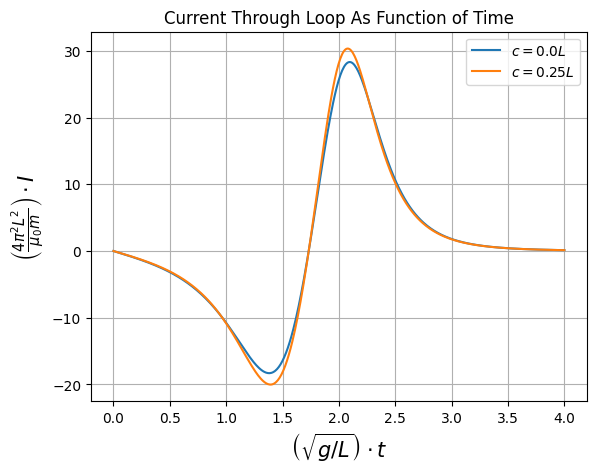

In [43]:
plt.plot(t.cpu(), current.cpu(), label=r'$c=0.0L$')
plt.plot(t.cpu(), current2.cpu(), label=r'$c=0.25L$')

plt.ylabel(r'$\left(\frac{4 \pi^2 L^2}{\mu_0 m}\right) \cdot I$', fontsize=15)
plt.xlabel(r'$\left(\sqrt{g/L}\right) \cdot t$', fontsize=15)
plt.grid()
plt.title('Current Through Loop As Function of Time')
plt.legend()

# Using CPU
- Scipys `nquad` function

In [67]:
def solve_numpy(t,a,h0,R,c):
    return nquad(integrand_f, [[0,a], [0,2*np.pi], [0,1], [0,2*np.pi]], args=(t,a,R,c,h0))[0]

def solve_multitimes_numpy(ts, a, h0, R, c):
    return np.vectorize(solve_numpy, otypes=[float])(ts, a, h0, R, c)

In [68]:
t_numpy = np.linspace(0,4,10)
current_numpy = solve_multitimes_numpy(ts=t_numpy,a=0.1,h0=1, R=1,c=0.0)

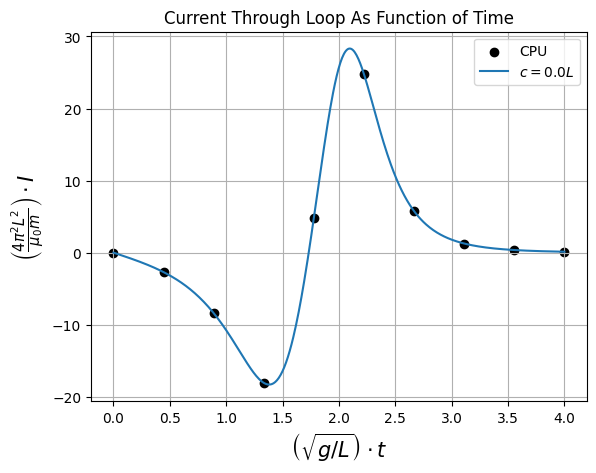

In [71]:
plt.scatter(t_numpy, current_numpy, color ='k', label='CPU')
plt.plot(t.cpu(), current.cpu(), label=r'$c=0.0L$')

plt.ylabel(r'$\left(\frac{4 \pi^2 L^2}{\mu_0 m}\right) \cdot I$', fontsize=15)
plt.xlabel(r'$\left(\sqrt{g/L}\right) \cdot t$', fontsize=15)
plt.grid()
plt.title('Current Through Loop As Function of Time')
plt.legend()